<a href="https://colab.research.google.com/github/ishwarraja/SOAI-ERAV2/blob/main/S7/ERA1S7F10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 103179362.11it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 54639464.96it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27205747.27it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14476085.69it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.13772453367710114 Batch_id=468 Accuracy=86.71: 100%|██████████| 469/469 [00:28<00:00, 16.25it/s]



Test set: Average loss: 0.0592, Accuracy: 9835/10000 (98.35%)

EPOCH: 1


Loss=0.055198922753334045 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:22<00:00, 20.45it/s]



Test set: Average loss: 0.0405, Accuracy: 9873/10000 (98.73%)

EPOCH: 2


Loss=0.036151349544525146 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:22<00:00, 20.41it/s]



Test set: Average loss: 0.0320, Accuracy: 9908/10000 (99.08%)

EPOCH: 3


Loss=0.0911199226975441 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:22<00:00, 20.78it/s]



Test set: Average loss: 0.0292, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.036948516964912415 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]



Test set: Average loss: 0.0311, Accuracy: 9895/10000 (98.95%)

EPOCH: 5


Loss=0.08444983512163162 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:21<00:00, 21.60it/s]



Test set: Average loss: 0.0274, Accuracy: 9909/10000 (99.09%)

EPOCH: 6


Loss=0.05768899619579315 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:22<00:00, 21.31it/s]



Test set: Average loss: 0.0209, Accuracy: 9928/10000 (99.28%)

EPOCH: 7


Loss=0.01121888030320406 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:22<00:00, 21.19it/s]



Test set: Average loss: 0.0213, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.027876662090420723 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:23<00:00, 19.61it/s]



Test set: Average loss: 0.0211, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.06485038250684738 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:23<00:00, 20.31it/s]



Test set: Average loss: 0.0208, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.02923075668513775 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:23<00:00, 20.19it/s]



Test set: Average loss: 0.0202, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.021940136328339577 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:23<00:00, 20.19it/s]



Test set: Average loss: 0.0211, Accuracy: 9925/10000 (99.25%)

EPOCH: 12


Loss=0.007960598915815353 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:23<00:00, 20.09it/s]



Test set: Average loss: 0.0203, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.027662212029099464 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:23<00:00, 20.11it/s]



Test set: Average loss: 0.0199, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.019131282344460487 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s]



Test set: Average loss: 0.0201, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.04912550747394562 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:22<00:00, 21.25it/s]



Test set: Average loss: 0.0196, Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.031307775527238846 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:22<00:00, 21.13it/s]



Test set: Average loss: 0.0194, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=0.014179547317326069 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:21<00:00, 21.32it/s]



Test set: Average loss: 0.0199, Accuracy: 9930/10000 (99.30%)

EPOCH: 18


Loss=0.03896094486117363 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]



Test set: Average loss: 0.0201, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.008872795850038528 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:22<00:00, 20.74it/s]



Test set: Average loss: 0.0195, Accuracy: 9930/10000 (99.30%)



# Let's Train and test our model

This time let's add a scheduler for out LR.

Text(0.5, 1.0, 'Test Accuracy')

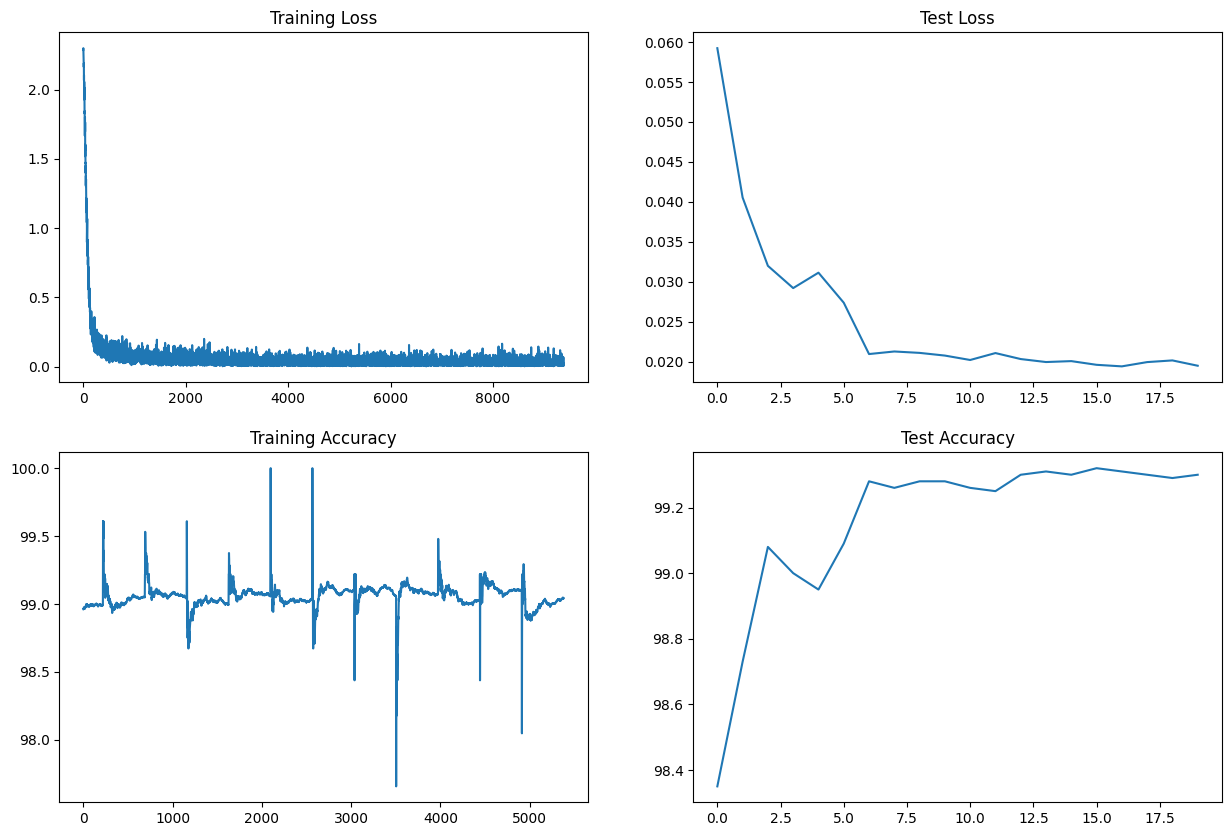

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(torch.tensor(train_losses))
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")